## Markov chain Monte Carlo
For this problem, you will be implementing a hierarchical Bayesian model and using a Markov chain Monte Carlo technique (Gibbs sampling) to approximate its predictions. In particular, you will implement the Beta-binomial model with an exponential prior used in Kemp et al. (2007) to understand how people learn {\em overhypotheses} --- beliefs about how properties tend to be distributed over different situations.  So, the Beta distribution is prominent in their model, which is a probability distribution over values between 0 and 1. The generative model for Beta-Binomial model with an exponential prior is

\begin{align*}
\alpha \sim {\rm Exponential}(1) & & \beta \sim {\rm Beta}(1,1) \\
 \theta_i | \alpha, \beta \sim {\rm Beta}\left(\alpha \beta, \alpha (1-\beta)\right) & & y_i | n_i, \theta_i \sim {\rm Binomial} (\theta_i; n_i)
\end{align*}

*Tip: Most programming languages provide functions for generating Exponential and Beta distributed random variables.*

Remember their cover story. Imagine that you come across a box filled with bags of marbles. Each bag has a lot of marbles. Each marble is either black or white. You get to observe $n_i$ marbles from bag $i$ and write down that $y_i$ of them are white. The proportion of white marbles in bag $i$ is $\theta_i$ (and because there are lots and lots of marbles in each bag, we can safely assume that $y_i$ is Binomial distributed with parameters $\theta_i$ and $n_i$). 

### 2a. Beta distributions

First, you will estimate the posterior distribution of a simplified version of the model: The posterior probability of the proportion of white marbles after seeing some marbles from a single bag without the hierarchical priors.  So, the generative process for this part is: $\theta_i | \alpha, \beta \sim {\rm Beta}\left(\alpha \beta, \alpha (1-\beta)\right)$ and $ y_i | n_i, \theta_i \sim {\rm Binomial} (\theta_i; n_i)$.

You can look up information about the Beta distribution on the Conjugate Prior page of Wikipedia. 

*Note that the notation here follows the notation used by Kemp et al. (2007). Wikipedia uses a different notation, which is actually the more standard one in statistics.}.*

The posterior distribution for a Beta-Binomial model is ${\rm Beta}\left( \alpha \beta + y_i, \alpha (1-\beta)+ (n_i-y_i) \right) $. This is the equation you need to complete this task. 

For each $\alpha$ and $\beta$ value, please graph:
1.  the prior distribution, (i.e. , no marbles observed) the posterior after observing one white marble (and zero black marbles)
2. the posterior distribution after observing 5 white and 5 black marbles, 
3. and the posterior distribution after observing 9 white and 1 black marble all on the same plot.

I provide the $a$ and $b$ values as well (which is usually what most programming languages expect) and correspond to the standard/Wikipedia parameterization of the Beta distribution).

### Please explore the following Beta distributions:
1.  $\alpha = 0.1$ and $\beta = 0.5$ ($a=0.05, b=0.05$)
2. $\alpha = 0.1$ and $\beta = 0.9$ ($a=0.09, b = 0.01$)
3. $\alpha = 1$ and $\beta = 0.5$ ($a=0.5, b = 0.5$)
4. $\alpha = 1$ and $\beta = 0.9$ ($a = 0.9, b = 0.1$)
5. $\alpha = 5$ and $\beta = 0.5$ ($a = 2.5, b = 2.5$)
6. $\alpha = 5$ and $\beta = 0.9$ ($a=4.5, b = 0.5$)

Although I expect you to execute and think about each of these, you are only required to turn in one of the graphs. Please turn in make sure that the graph is visible and each distribution is distinct and clearly labelled. Please write a paragraph describing how changing $\alpha$ and $\beta$ affect the posterior update.

In [4]:
# distributions when parametrizing with alpha and beta
distributions_orig = [
    (0.1, 0.5), # alpha = 0.1, beta = 0.5
    (0.1, 0.9),
    (1.0, 0.5),
    (1.0, 0.9),
    (5.0, 0.5),
    (5.0, 0.9),
]

# distributions when parametrizing with a and b (standard)
distributions_wiki = [
    (0.05, 0.05), # a = 0.05, b = 0.05
    (0.09, 0.01),
    (0.50, 0.50),
    (0.90, 0.10),
    (2.50, 2.50),
    (4.50, 0.50),
]

num_observed = [
    (0, 0), # 0 white, 0 black <-- prior distribution!
    (1, 0), # 1 white, 0 black
    (5, 5),
    (9, 1),
]

In [22]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

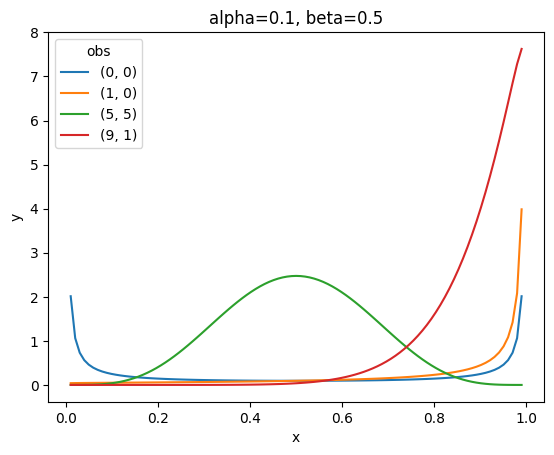

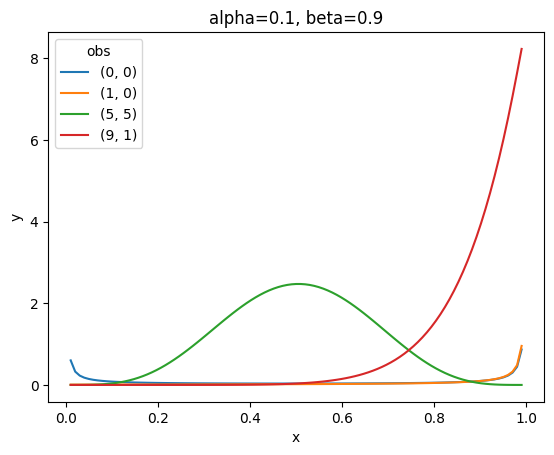

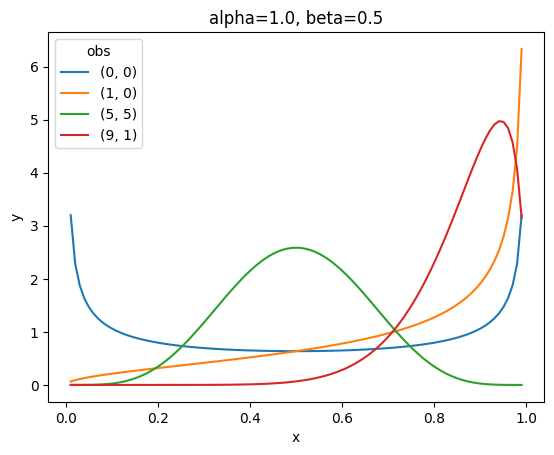

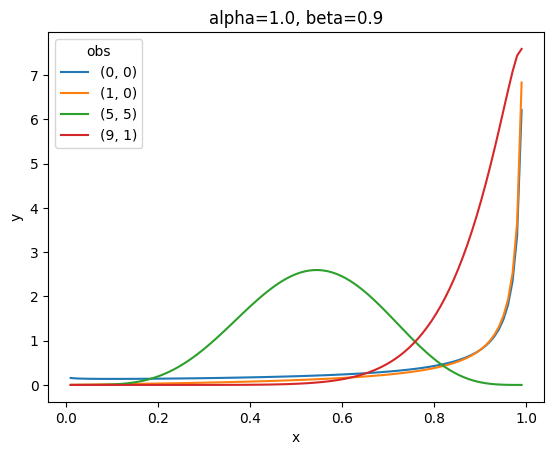

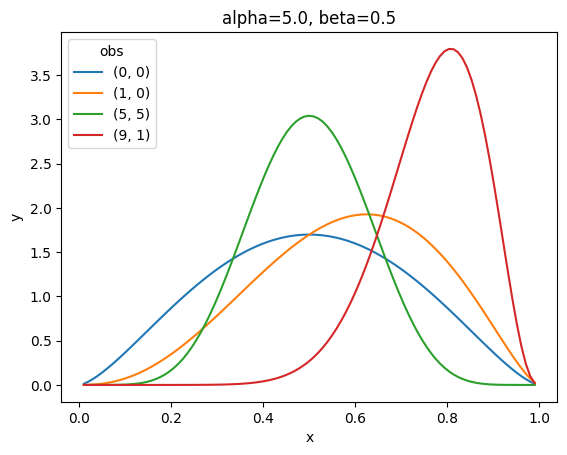

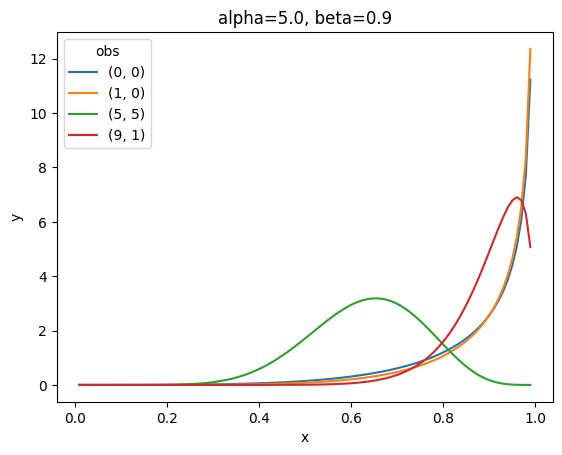

<Figure size 640x480 with 0 Axes>

In [28]:
for (Alpha, Beta), (a, b) in zip(distributions_orig, distributions_wiki):
    # Beta roughly corresponds to mean
    # Alpha is the "sample size"

    dfs = []
    x = np.linspace(start=0.01, stop=1-0.01, num=101)
    for observed in num_observed:
        obs_wht, obs_blk = observed
        n = obs_wht + obs_blk
        a_obs = a + obs_wht
        b_obs = b + (n - obs_wht)
        probs = beta.pdf(x, a_obs, b_obs)
        df = pd.DataFrame(data={'x': x, 'y': probs, 'obs': str(observed)})
        dfs.append(df)
        pass

    dfs_concat = pd.concat(dfs)
    sb.lineplot(data=dfs_concat, x='x', y='y', hue='obs')
    plt.title(f'alpha={Alpha}, beta={Beta}')
    plt.figure()

The Beta parameter places a prior on the mean of the curve.

Alpha, as described on Wikipedia, is the "sample size" parameter. The higher it is, the more samples are required to more the probability mass of the distribution away from the mean.

### 2b. Implementing a MCMC sampler
Now you will implement samplers to estimate the posterior distribution on $\alpha$, $\beta$, and $\theta_1,\dotsc \theta_M$ after observing some marbles from $M$ bags (i.e., given $y_1, \dotsc, y_M,n_1,\dotsc,n_M$) and the predictive probability for the probability of white marbles in new bags after observing some marbles from some bags (i.e., given $y_1, \dotsc, y_M,n_1,\dotsc,n_M$). We will be approximating the posterior distribution of $\theta_1\dotsc,\theta_M$ using Gibbs sampling steps and interleaving these steps with Metropolis-Hastings Markov chain Monte Carlo (MH MCMC) sampling for $\alpha$ and $\beta$. 

Here is an overview of the process:  
1. Initialize $\alpha$ and $\beta$ by sampling them from their priors (Exponential(1) and Beta(1,1), respectively).
2. Sample a value for each $\theta_m$ of the $M$ bags based on current $\alpha$ and $\beta$.
3. Sample new proposal values for $\alpha$ and $\beta$ given the $M$ sampled $\theta$ values via an equation provided in the detailed procedure below.
4. Accept the proposed $\alpha$ and $\beta$, or to keep the previous values. 
5. Repeat from 2 until convergence

To implement the Gibbs sampling portion, we iterate through the bags and for each bag, we resample the current value for the proportion of white marbles in bag $i$ ($\theta_i^{(t)}$) given the value of all other variables (so, given $\theta_1^{(t-1)}, \dotsc, \theta_{i-1}^{(t-1)}, \dotsc$, $\theta_{i+1}^{(t-1)}, \dotsc, \theta_M^{(t-1)}, \alpha^{(t)}, \beta^{(t)}, {\bf y}, {\bf n}$). Given $\alpha$ and $\beta$ all of the bags are independent of each other (if you're not sure, use the conditional independence rules for graphical models we discussed in class), and so, we sample $\theta_i^{(t)} | \alpha^{(t)}, \beta^{(t)}, y_i, n_i$. Fortunately, we already know this from the last subproblem! It's a Beta-Binomial model and so

\begin{equation*}
\theta_i^{(t)} | \alpha^{(t)}, \beta^{(t)}, y_i, n_i \sim {\rm Beta}\left( \alpha^{(t)} \beta^{(t)} + y_i, \alpha^{(t)} (1-\beta^{(t)})+ (n_i-y_i) \right)
\end{equation*} 

The sampler for $\alpha$ is a bit more tricky because an explicit solution for the posterior distribution of $\alpha |\theta_1,\dotsc, \theta_M $ is unknown. To implement the MH MCMC, we successively generate new proposed values for $\alpha$ and $\beta$ given its previous value. For $\alpha$, we will use the Student's $t$ distribution with one-degree of freedom and a mean centered at the current sample for $\alpha$, $\alpha^{(t)}$ (under the constraint that $\alpha^{(t+1)} > 0$).

We do so that we normally propose to change $\alpha$ to values near the current one, but also occasionally propose very different values, which can help the Markov chain ``mix'' better. Student's $t$ probability distribution with one degree of freedom is 
%next year make this clearer
\begin{equation*}
f(x) = \frac{1}{\pi (1+x^2)}
\end{equation*}
So, our proposal distribution $q(\alpha'| \alpha^{(t)}) = (\alpha^{(t)} + X^{(t)}) I( \alpha^{(t)} + X^{(t)}>0 )$, where $X \sim {\rm Student's \ } t(1)$ (Note the $'$ is used to denote the proposed new value of the corresponding variable -- in this case $\alpha$).  Choosing a proposal distribution for $\beta$ is simpler. It will be a Beta distribution whose mean is $\beta_{t}$ and has a bit of variance. So, $q(\beta'|\beta^{(t)})$ is ${\rm Beta}(1+\beta^{(t)}, 2-\beta^{(t)})$.


To implement MH MCMC, we first initialize the Markov chain by a random sample from the prior ($\alpha^{(1)} \sim {\rm Exponential}(1)$ and $\beta^{(1)} \sim {\rm Beta}(1,1)$) and then for $t =1,\dotsc, T$ follow the following steps:

1. Do a ``sweep'' (resample each $\theta^{(t)}_i$ once) of Gibbs sampling. You should sample the $M$ bags in a random order each sweep.So, resample each $\theta_i$:  $\theta_i^{(t)} | \alpha^{(t)}, \beta^{(t)}, y_i, n_i \sim {\rm Beta}\left( \alpha^{(t)} \beta ^{(t)}+ y_i, \alpha^{(t)} (1-\beta^{(t)})+ (n_i-y_i) \right)$
2. Generate a proposed next state for the sampler using the current state. To do so, sample $\alpha'$ by adding  $X \sim {\rm Student's \ }t(1)$ to $\alpha^{(t)}$ and sample $\beta' | \beta^{(t)} \sim {\rm Beta}(1+\beta^{(t)}, 2-\beta^{(t)})$.
3. Calculate the probability $c$ that we accept $\alpha'$ and $\beta'$ as the next state. Because the proposal distribution for $\alpha$ is symmetric, we do not need to include it in our acceptance term. However, the proposal distribution for $\beta$ is not symmetric, and so the MH requires a correction term to ensure that the probability that we move back and forth between states. So, the acceptance probability is the product of two probabilities: (1) the ratio of the probability of transitioning from the proposal back to the current state to the probability of the reverse transition and (2) the ratio of the posterior probability of the proposal to the posterior probability of the previous sample.  Don't worry. I've done the derivation for you (it is straightforward, so it's a good exercise to do if you are curious!). It is \begin{align*}
c &= \frac{q(\beta^{(t)}|\beta') p(\alpha', \beta' | \theta_1^{(t)}, \dotsc, \theta_M^{(t)})}{q(\beta'|\beta^{(t)}) p(\alpha^{(t)}, \beta^{(t)} | \theta_1^{(t)}, \dotsc, \theta_M^{(t)}) } \\
 &= \frac{ \texttt{betapdf}(\beta^{(t)}; 1+ \beta', 2-\beta') p(\alpha') p(\beta') \prod_{i}{p\left( \theta_i^{(t)} | \alpha', \beta' \right)}} { \texttt{betapdf}(\beta'; 1+\beta^{(t)},2-\beta^{(t)}) p(\alpha^{(t)})p(\beta^{(t)})\prod_{i}{p\left( \theta_i^{(t)} | \alpha^{(t)}, \beta^{(t)} \right)}}
\end{align*}
where $\texttt{betapdf(x;y,z)}$ is the amount of density at $x$ given by a Beta function with parameters $y$ and $z$.
4. Sample $ Y \sim U(0,1)$. If $Y \leq c$, $\left(\alpha^{(t+1)},  \beta^{(t+1)}\right) = (\alpha', \beta')$. Otherwise, reject and the next sample is the same as $t$: $\left(\alpha^{(t+1)},  \beta^{(t+1)}\right)=\left(\alpha^{(t)},  \beta^{(t)}\right)$



Now we use the sampler to explore the model's behavior given different sets of marble bags. Please use the following sets of marble bags:
1. 10 bags where each bag has 9 white and 11 black marbles.
2. 5 bags with 1 white and 19 black marbles, and 5 bags with 19 white and 1 black marble.

For each of these, please run the sampler for 3000 sweeps ($T=3000$). Please include (two separate) histograms of the $\alpha$ samples and $\beta$ samples for both I. and II. Also, calculate the average $\alpha$ and $\beta$ value, and the expected value for a new bag of marbles ($\theta_{M+1}$) after observing the bags of marbles for each (note that this is $\frac{\bar{\alpha} \bar{\beta}}{\bar{\alpha} \bar{\beta}+ \bar{\alpha}(1- \bar{\beta})}$, where $\bar{\cdot}$ is the average of that variable). 

In [2]:
#fill me

Please write two paragraphs. In the first paragraph, describe the histograms for $\alpha$ and $\beta$ given each set of marble bags and explain what their values mean. In the second paragraph, compare the histograms and the values you were asked to calculate. What is equal and unequal? Explain why.


Fill me